# Gaussian Processes and Gaussian Process Regression

This notebook will walk through the key mathematical details required to understand what a Gaussian Process is and how Gaussian Process Regression works.


In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import binom, beta

np.random.seed(15)

Just as a multivariate normal distribution is completely specified by a mean vector and covariance matrix, a Gaussian Process is fully specified by a mean function and a covariance function

$$p(x) \sim \mathcal{GP}(m(x), k(x,x'))$$

For example, take the mean function equal to 0 and the squared exponential covariance function

$$m(x) = 0$$
$$k(x,x') = \theta_1 \cdot exp \left(- \frac{\theta_2}{2}(x - x')^2 \right)$$

It turns out that most of the learning in the GP involves the covariance function and its hyperparameters, so very little is gained in specifying a complicated mean function. It is common to take a mean function of 0 as the prior and rely completely on the covariance function for learning.

Let's walk through a Gaussian Process Regression example using the prior GP we just defined above. First we define the mean and covariance functions. We will start with hyperpareters $\sigma_0 = 1$, $\sigma_1=10$.

In [3]:
xpts = np.linspace(-3, 3, 1000)

mean_prior = [0 for x in xpts]

def exponential_cov(x, y, params):
    return params[0] * np.exp(-0.5 * params[1] * np.subtract.outer(x, y)**2)

theta = [1, 10]

sigma_0 = exponential_cov(0, 0, theta)

print(sigma_0)

1.0


Based on the prior and hyperparameters we chose, the mean at every point in our domain is 0 and the standard deviatoin at every point in our domain is 1. It is important to remember that each value on the $x$ axis has a corresponding normal distribution. That is, the value $x = 1$ has a normal distribution represented by $y$ values along the $y$ axis. So does $x = \pi$, $x = e$, and $x = -1.23$, etc. This GP represents uncountbaly infinite normal distributions. That being said, we only need to store in the computer those of which we want to compute.

Below we plot our GP prior.

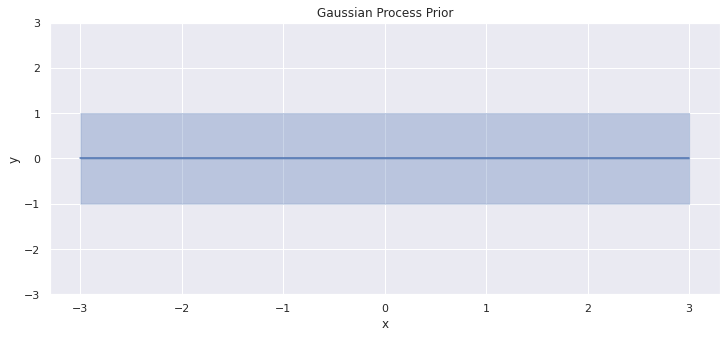

In [8]:
sns.set(rc = {'figure.figsize':(12,5)})

plt.plot(xpts, mean_prior, label="mean");
stdev_plus = [x + sigma_0 for x in mean_prior]
stdev_minus = [x - sigma_0 for x in mean_prior]
plt.fill_between(xpts, stdev_plus, color="b", alpha=0.3);
plt.fill_between(xpts, stdev_minus, color="b", alpha=0.3);
plt.ylim(-3, 3);
plt.xlabel("x");
plt.ylabel("y");
plt.title("Gaussian Process Prior");

We have our first Gaussian Process! Lets take a sample at a random point, say 1, to make our first observation. The default values for np.random.normal() are a mean of 0 and a standard deviation of 1, so that will work as our first sample.

In [9]:
x = [1.]
y = [np.random.normal()]
print(f"x: {x}")
print(f"y: {y}")

# New sigma
sigma_1 = exponential_cov(x, x, theta)
print(f"sigma_1: {sigma_1}")

x: [1.0]
y: [-0.3123284815435444]
sigma_1: [[1.]]


Now we have our first observation, $(1, -0.312)$. From here, we will need to use some conditioning formulas for multivariate Gaussian Distributions so we can condition our Gaussian Process prior on this observation and obtain our Posterior. The conditioning property of multivariate Gaussian Distributions gives us the following mean and covariance fucntions for $p(x|y)$

$$\mu = \mu_x + \Sigma_{xy} \Sigma_y^{-1}(y - \mu_y)$$
$$\sigma = \Sigma_x - \Sigma_{xy} \Sigma_y^{-1} \Sigma_{yx}$$

Our first oberservation is $(1, -0.312)$. We will need to compute the resulting normal distribution at all the remaining points in xpts. To help us understand how that calculation works, let us start with a single unkown point from xpts, say $x=0.7$. We want to know the probability distribution for $y$ at $x=0.7$ given the data we know, by using the formulas above. Let's take $x_0 = 1$ and $x_1 = 0.7$.

Remember! Here $x_0$ and $x_1$ represent normal distributions, it is confusing to keep track of this, I know. Moreover, $x_0$ has been observed and no longer represents a normal distribution, we take the value of $-0.312$ for $x_0$. (yikes)

$p(x_1 \; | \; x_0 = -0.312)$

$\mu = \mu_{x_1} + \Sigma_{x_1 x_0} \Sigma^{-1}_{x_0} (x_0 - \mu_{x_0})$

$\sigma = \Sigma_{x_1} - \Sigma_{x_1 x_0} \Sigma^{-1}_{x_0} \Sigma_{x_0 x_1}$

Let's calculate this!

In [12]:
x_1 = 0.7

# covariance matrix for known data
Sigma_x = np.array([exponential_cov(x, x, theta)])
# covariance matrix for new data
Sigma_x1 = np.array([exponential_cov(x_1, x_1, theta)])

# covariance matricies for interactions between known and new data
Sigma_x1_x = np.array([exponential_cov(x_1, x, theta)])
Sigma_x_x1 = np.array([exponential_cov(x, x_1, theta)])

# inverse of Sigma_x_0
Sigma_x_inv = np.linalg.inv(Sigma_x)

mu = 0 + np.dot(Sigma_x1_x, Sigma_x_inv).dot(y)
sigma = Sigma_x1 - np.dot(Sigma_x1_x, Sigma_x_inv).dot(Sigma_x_x1)

print(mu.squeeze(), sigma.squeeze())

-0.19914943238544533 0.593430340259401


Turn this into a function.

In [14]:
def conditional(x_new, x, y, params):
    Sigma_x_new_x = exponential_cov(x_new, x, params)
    Sigma_x_x_new = exponential_cov(x, x_new, params)
    Sigma_x_x = exponential_cov(x, x, params)
    Sigma_x_new_x_new = exponential_cov(x_new, x_new, params)

    Sigma_x_inv = np.linalg.inv(Sigma_x_x)

    mu = 0 + np.dot(Sigma_x_new_x, Sigma_x_inv).dot(y)
    sigma = Sigma_x_new_x_new - np.dot(Sigma_x_new_x, Sigma_x_inv).dot(Sigma_x_x_new)
    return(mu.squeeze(), sigma.squeeze())

In [15]:
conditional(0.7, x, y, theta)

(-0.19914943238544533, 0.593430340259401)

We will take a finite collection of points in our domain, then determine the normal distribution at each point given our conditional fucntion, then plot said distributions to get our posterior GP.

In [17]:
x_pred = np.linspace(-3, 3, 1000)
predictions = [conditional(i, x, y, theta) for i in x_pred]
y_means, y_sigmas = np.transpose(predictions)

Plot the results:

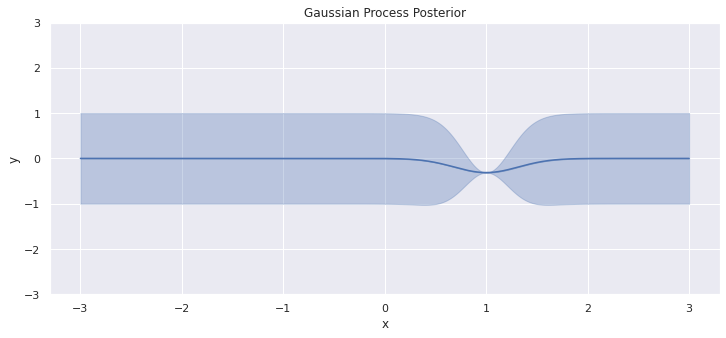

In [19]:
plt.plot(x_pred, y_means, label="mean");
stdev_plus = [y_mean + abs(y_sigma) for y_mean, y_sigma in zip(y_means, y_sigmas)]
stdev_minus = [y_mean - y_sigma for y_mean, y_sigma in zip(y_means, y_sigmas)]
plt.fill_between(x_pred, y_means, stdev_plus, color="b", alpha=0.3);
plt.fill_between(x_pred, y_means, stdev_minus, color="b", alpha=0.3);
plt.ylim(-3, 3);
plt.xlabel("x");
plt.ylabel("y");
plt.title("Gaussian Process Posterior");

To help understand what has chanaged, consider how the distribution for $0.7$ has been conditioned on our known data $x$. We can pull this distrubution for $x=0.7$ by evaluating our `conditional` function at $x=0.7$ using our known data.

In [20]:
mu, sigma = conditional(0.7, x, y, theta)
print(mu, sigma)

-0.19914943238544533 0.593430340259401


Plot this distrubtion over our posterior GP

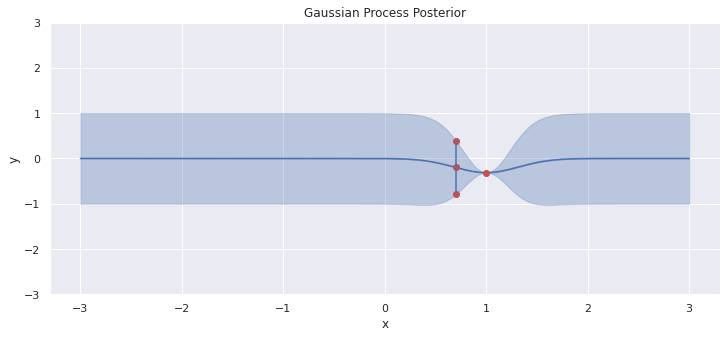

In [21]:
sns.set()
plt.plot(x_pred, y_means, label="mean");
stdev_plus = [y_mean + abs(y_sigma) for y_mean, y_sigma in zip(y_means, y_sigmas)]
stdev_minus = [y_mean - y_sigma for y_mean, y_sigma in zip(y_means, y_sigmas)]
plt.fill_between(x_pred, y_means, stdev_plus, color="b", alpha=0.3);
plt.fill_between(x_pred, y_means, stdev_minus, color="b", alpha=0.3);
plt.plot(x, y, "ro");
plt.ylim(-3, 3);
plt.xlabel("x");
plt.ylabel("y");
plt.title("Gaussian Process Posterior");

plt.plot(0.7, mu, "ro");
plt.plot(0.7, mu + sigma, "ro");
plt.plot(0.7, mu - sigma, "ro");
plt.vlines(x=0.7, ymin=mu-sigma, ymax=mu+sigma);

Next, take another sample from one of the uncountably infinite normal distributions, say $x = -1.5$. First, calculate the normal distribution at $x = -1.5$. Then take a sample from that distribution as our next observation.

In [22]:
x_1 = -1.5
# Get the normal distribution at -1.5
mu, sigma = conditional(x_1, x, y, theta)

# Sample the distribution to make our next observation
y_1 = np.random.normal(mu, sigma)
print(y_1)

# Append the new data
x.append(x_1)
y.append(y_1)

0.339284706046176


Calculate the resulting posterior GP and plot.

In [23]:
predictions = [conditional(i, x, y, theta) for i in x_pred]
y_means, y_sigmas = np.transpose(predictions)

We get the following Posterior Gaussian Process

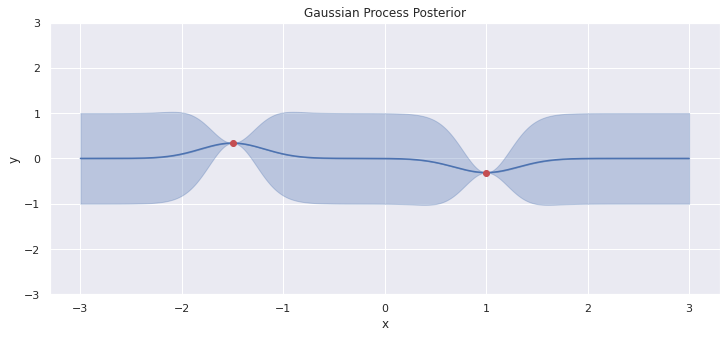

In [24]:
plt.plot(x_pred, y_means, label="mean");
stdev_plus = [y_mean + abs(y_sigma) for y_mean, y_sigma in zip(y_means, y_sigmas)]
stdev_minus = [y_mean - y_sigma for y_mean, y_sigma in zip(y_means, y_sigmas)]
plt.fill_between(x_pred, y_means, stdev_plus, color="b", alpha=0.3);
plt.fill_between(x_pred, y_means, stdev_minus, color="b", alpha=0.3);
plt.plot(x, y, "ro");
plt.ylim(-3, 3);
plt.xlabel("x");
plt.ylabel("y");
plt.title("Gaussian Process Posterior");

In [25]:
x_observations = [-2.1, -0.5, 0.3, 1.8, 2.5]
mu, s = conditional(x_observations, x, y, theta)
y_sample = np.random.multivariate_normal(mu, s)

In [26]:
x += x_observations
y += y_sample.tolist()

In [27]:
predictions = [conditional(i, x, y, theta) for i in x_pred]
y_means, y_sigmas = np.transpose(predictions)

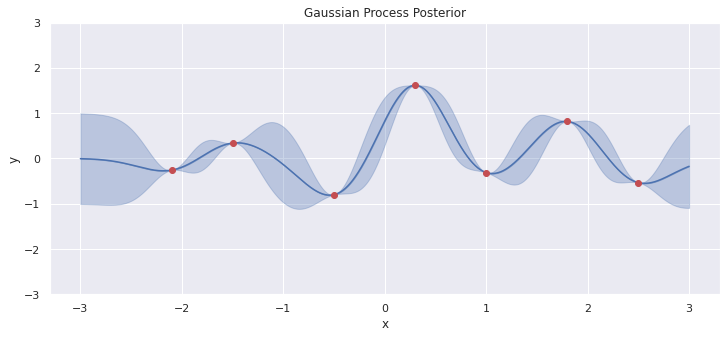

In [28]:
plt.plot(x_pred, y_means, label="mean");
stdev_plus = [y_mean + abs(y_sigma) for y_mean, y_sigma in zip(y_means, y_sigmas)]
stdev_minus = [y_mean - y_sigma for y_mean, y_sigma in zip(y_means, y_sigmas)]
plt.fill_between(x_pred, y_means, stdev_plus, color="b", alpha=0.3);
plt.fill_between(x_pred, y_means, stdev_minus, color="b", alpha=0.3);
plt.plot(x, y, "ro");
plt.ylim(-3, 3);
plt.xlabel("x");
plt.ylabel("y");
plt.title("Gaussian Process Posterior");